In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import seaborn as sn



In [47]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_clean.csv')
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
853,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
all_inputs = df[df.loc[:, "Gender":].columns.values.tolist()].values

all_labels = df['Grade'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

# Generate the same cross validation strategy for all classifiers for better comparison
cross_validation = StratifiedKFold(n_splits=5)

# Classifier/Model Results dictionary
results = {}

In [49]:
X = df.drop(columns=["Grade"])

y = df["Grade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

selector = SelectKBest(score_func=chi2, k=12)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)



#### Function to test the Model/Classifier

In [50]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

#### Support Vector Machine (SVM) with Hyperparameterization

In [51]:
svm = SVC(probability=True)
svm.fit(X_train_selected, y_train)

parameter_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],         
    'degree': [2, 3, 4],   
    'class_weight': [None, 'balanced'], 
    'probability': [True]             
}
result = test_model(svm, parameter_grid)

results['Support Vector Machine'] = result

Best: 0.870502 using {'C': 100, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'probability': True}
0.736264 (0.029425) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'scale', 'probability': True}
0.744458 (0.030327) with: {'C': 0.1, 'class_weight': None, 'degree': 4, 'gamma': 'auto', 'probability': True}
0.728145 (0.031240) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'probability': True}
0.739834 (0.028338) with: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'auto', 'probability': True

Text(33.22222222222222, 0.5, 'Truth')

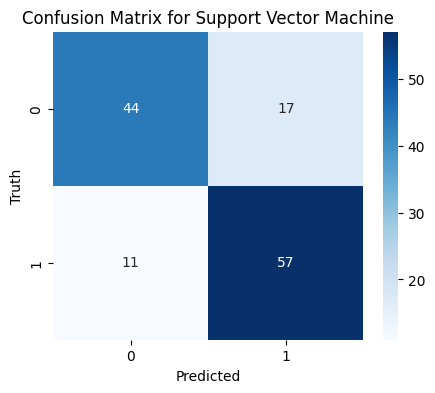

In [52]:
y_predicted = svm.predict(X_test_selected)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Truth')

#### K Nearest Neighbors

In [53]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

parameter_grid = {
    'n_neighbors': [3, 5, 7, 9],          
    'weights': ['uniform', 'distance'],   
    'metric': ['euclidean', 'manhattan', 'minkowski'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  
    'leaf_size': [30, 40, 50],            
    'p': [1, 2]                           
}
result = test_model(knn, parameter_grid)

results['K Nearest Neighbors'] = result

Best: 0.835475 using {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.801680 (0.022345) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.793506 (0.022570) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.800503 (0.017783) with: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.807494 (0.012377) with: {'algorithm': 'auto', 'l

Text(33.22222222222222, 0.5, 'Truth')

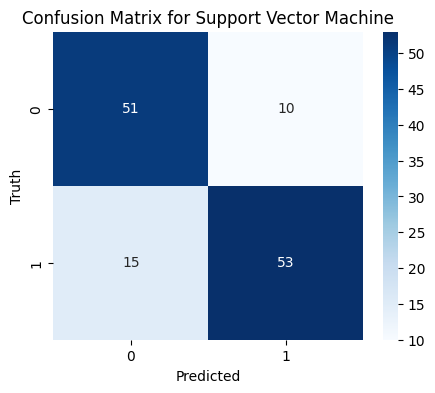

In [54]:
y_predicted = knn.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Truth')